In [1]:
import torch
from utils import process_dataset
from argparse import ArgumentParser
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import numpy as np
import random

seed = 123
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

/home/vincent0730/ML_pondlet_level_predictor/venv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# datasets = "../datasets/pondlet_gloss_HSK3_2021-all.csv;../datasets/pondlet_STB_HSK3_2021-all.csv"
datasets = "../datasets/pondlet_STB_HSK3_20220429_new.csv"
balance_data = process_dataset(datasets)
balance_data.drop("ID", inplace=True, axis=1)
#balance_data.drop("None", inplace=True, axis=1)
#balance_data.drop("7-9", inplace=True, axis=1)

datasets ../datasets/pondlet_STB_HSK3_20220429_new.csv
len-balance_data(one) 1616


In [3]:
balance_data.head()

,Label,Length,1,2,3,4,5,6,7-9,None
0,Lv.1,100,48,3,10,0,0,0,8,1
1,Lv.4,314,107,39,12,13,5,4,22,0
2,Lv.1,38,24,0,0,0,0,0,0,0
3,Lv.6,610,166,63,58,36,12,27,24,5
4,Lv.3,253,85,30,6,4,9,2,4,8


In [4]:
np_label = balance_data["Label"].to_numpy()
class_weights = compute_class_weight("balanced", np.unique(np_label), np_label)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights

/home/vincent0730/ML_pondlet_level_predictor/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=['Lv.1' 'Lv.2' 'Lv.3' 'Lv.4' 'Lv.5' 'Lv.6'], y=['Lv.1' 'Lv.4' 'Lv.1' ... 'Lv.2' 'Lv.5' 'Lv.3'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


tensor([1.9804, 1.8198, 0.9619, 0.4387, 0.8860, 2.0100])

In [5]:
balance_data.Label.value_counts()

Lv.4    614
Lv.5    304
Lv.3    280
Lv.2    148
Lv.1    136
Lv.6    134
Name: Label, dtype: int64

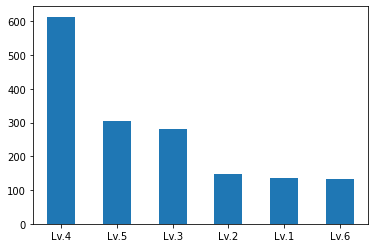

In [6]:
balance_data.Label.value_counts().plot.bar(rot=0);

In [7]:
X = balance_data.iloc[:, 1:].to_numpy()

le = preprocessing.LabelEncoder()
le.fit(balance_data.Label)
balance_data['categorical_label'] = le.transform(balance_data.Label)
y = balance_data.iloc[:, -1].to_numpy()


# ['Lv.1' 'Lv.2' 'Lv.3' 'Lv.4' 'Lv.5' 'Lv.6']
print(le.classes_)


X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.1, stratify=y_tmp, random_state=42)

['Lv.1' 'Lv.2' 'Lv.3' 'Lv.4' 'Lv.5' 'Lv.6']


In [8]:
le.inverse_transform([y_tmp[0]])

array(['Lv.3'], dtype=object)

In [9]:
le.classes_.tolist()

['Lv.1', 'Lv.2', 'Lv.3', 'Lv.4', 'Lv.5', 'Lv.6']

In [10]:
import torch
import torch.nn.functional as F
import torch.nn as nn

In [11]:
class Model(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 8)
        self.layer2 = nn.Linear(8, 16)
        self.layer3 = nn.Linear(16, 24)
        self.layer4 = nn.Linear(24, 32)
        self.layer5 = nn.Linear(32, 64)
        self.layer6 = nn.Linear(64, 32)
        self.layer7 = nn.Linear(32, 24)
        self.layer8 = nn.Linear(24, 16)
        self.layer9 = nn.Linear(16, output_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        x = F.relu(self.layer6(x))
        x = F.relu(self.layer7(x))
        x = F.relu(self.layer8(x))
        return self.layer9(x)


In [12]:
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):        
        return self.x[idx], self.y[idx]

In [13]:
from torch.utils.data import DataLoader

X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)
test = CustomDataset(X_test, y_test)
test_dataloader = DataLoader(test, batch_size=1, shuffle=True)

In [14]:
loss_fn   = nn.CrossEntropyLoss(weight=class_weights)

In [15]:
def train_one_epoch(train_dataloader, model, optimizer):

    train_correct = 0
    train_total = 0
    train_loss = 0.0

    for i, data in enumerate(train_dataloader, 0):

        inputs, labels = data

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        values, indices = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (indices == labels).sum().item()

    acc = 100 * train_correct / train_total
    loss = train_loss / len(train_dataloader)
    return acc, loss

In [16]:
def val_one_epoch(val_dataloader, model):

    val_correct = 0
    val_total = 0
    val_loss = 0

    with torch.no_grad():

        for data in val_dataloader:

            inputs, labels = data
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            values, indices = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (indices == labels).sum().item()

    acc = 100 * val_correct / val_total
    loss = val_loss / len(val_dataloader)
    return acc, loss

In [17]:
def test_at_final(test_dataloader, model):

    test_correct = 0
    test_total = 0
    y_true, y_pred = [], []
    
    with torch.no_grad():

        for data in test_dataloader:

            inputs, labels = data
            outputs = model(inputs)
            values, indices = torch.max(outputs.data, 1)
            # 忽略label是lv.6，預測不是lv.6的錯誤
            # if labels.item() == 5 and indices.item() != 5:
            #     continue

            # # 忽略label不是lv.6，預測是lv.6的錯誤
            # if labels.item() != 5 and indices.item() == 5:
            #     continue

            test_total += labels.size(0)
            test_correct += (indices == labels).sum().item()
            

            y_true.extend(labels.tolist())
            y_pred.extend(indices.tolist())

    acc = 100 * test_correct / test_total
    array = confusion_matrix(y_true, y_pred)
    return acc, array

In [18]:
X_tmp.shape, X_test.shape

((1454, 9), torch.Size([162, 9]))

In [19]:
y_test

tensor([2, 3, 2, 5, 3, 0, 3, 4, 2, 4, 3, 2, 4, 2, 0, 2, 4, 0, 3, 3, 3, 5, 1, 1,
        3, 4, 0, 2, 3, 0, 3, 3, 1, 1, 4, 5, 0, 5, 3, 4, 2, 4, 0, 0, 2, 4, 5, 4,
        3, 1, 1, 3, 1, 4, 3, 1, 4, 5, 4, 2, 4, 3, 3, 1, 4, 3, 3, 3, 3, 3, 4, 3,
        2, 3, 1, 3, 3, 5, 2, 3, 0, 4, 0, 3, 2, 3, 1, 2, 3, 3, 0, 0, 3, 3, 3, 2,
        3, 4, 3, 5, 3, 3, 5, 3, 2, 2, 3, 0, 4, 3, 2, 2, 3, 2, 4, 4, 3, 2, 4, 3,
        4, 3, 4, 3, 2, 5, 1, 3, 1, 3, 3, 3, 0, 3, 1, 3, 3, 3, 2, 2, 3, 3, 5, 5,
        5, 4, 3, 3, 4, 3, 3, 3, 4, 2, 4, 4, 2, 3, 2, 1, 4, 2])

In [20]:
skf = StratifiedKFold(n_splits=4, random_state=seed, shuffle=True)
kfold_train_acc = []
kfold_val_acc = []
kfold_test_acc = []
cf_arrays = []

for i, (train_index, val_index) in enumerate(skf.split(X_tmp, y_tmp)):
    X_train, X_val = X_tmp[train_index], X_tmp[val_index]
    y_train, y_val = y_tmp[train_index], y_tmp[val_index]

    X_train = torch.FloatTensor(X_train)
    X_val = torch.FloatTensor(X_val)
    y_train = torch.LongTensor(y_train)
    y_val = torch.LongTensor(y_val)

    train = CustomDataset(X_train, y_train)
    val = CustomDataset(X_val, y_val)

    train_dataloader = DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val, batch_size=8, shuffle=True)

    model     = Model(X_train.shape[1], len(le.classes_))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []

    for _ in tqdm(range(3000)):
        train_acc, train_loss = train_one_epoch(train_dataloader, model, optimizer)
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)

        val_acc, val_loss = val_one_epoch(val_dataloader, model)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    test_acc, cf_array = test_at_final(test_dataloader, model)
    cf_arrays.append(cf_array)

    kfold_train_acc.append(np.mean(train_acc_list))
    kfold_val_acc.append(np.mean(val_acc_list))
    kfold_test_acc.append(test_acc)
    torch.save(model.state_dict(), f"model_fold{i}.pt")


  0%|          | 0/3000 [00:00<?, ?it/s]/home/vincent0730/ML_pondlet_level_predictor/venv/lib/python3.6/site-packages/torch/autograd/__init__.py:156: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
100%|██████████| 3000/3000 [18:29<00:00,  2.70it/s]


In [21]:
kfold_train_acc

[87.34544342507645, 89.63281345565748, 91.82242590895204, 89.56021998166821]

In [22]:
kfold_val_acc

[76.5893772893773, 79.6717032967033, 81.85169880624426, 76.06648301193755]

In [23]:
kfold_test_acc

[83.33333333333333, 72.8395061728395, 83.33333333333333, 76.54320987654322]

In [24]:
labels, counts = np.unique(y_test, return_counts=True)
for l, c in zip(labels, counts):
    print(f"Lable:{l}, Count:{c}")

Lable:0, Count:14
Lable:1, Count:15
Lable:2, Count:28
Lable:3, Count:62
Lable:4, Count:30
Lable:5, Count:13


In [25]:
print(f"Baseline acc:{100*counts.max()/counts.sum():.2f}")
print(f"4 folds  acc:{np.mean(kfold_test_acc):.2f}")

Baseline acc:38.27
4 folds  acc:79.01


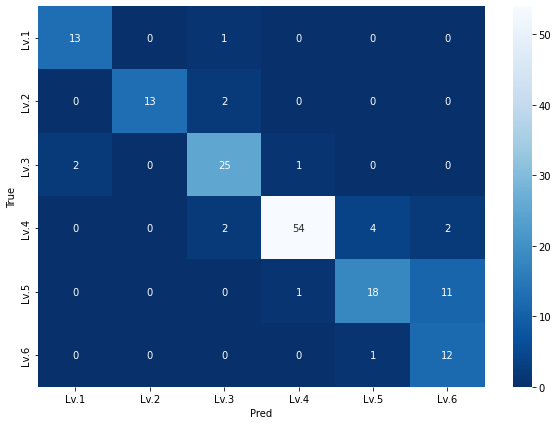

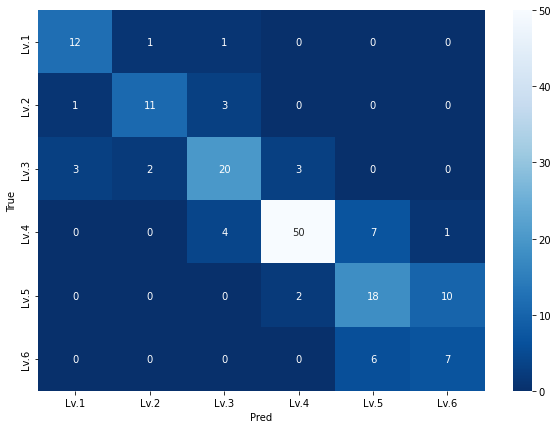

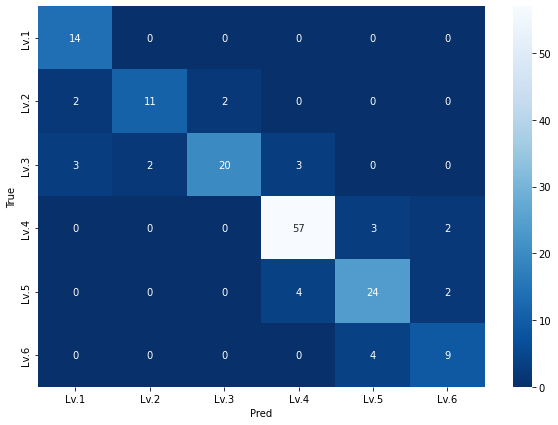

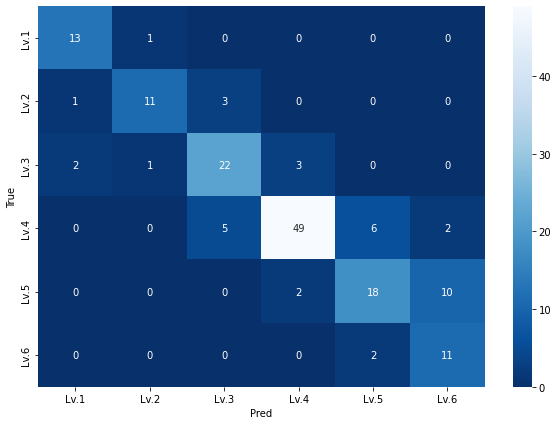

In [26]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


for array in cf_arrays:
    df_cm = pd.DataFrame(array, index = le.classes_.tolist(),
                    columns = le.classes_.tolist())
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, cmap="Blues_r")
    plt.xlabel('Pred')
    plt.ylabel('True')
    plt.show();